<a href="https://colab.research.google.com/github/dsisadrug/DS_mentoring_2021/blob/main/DSynak_NLP_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install bds_courseware

All of the modules below were found to be useful and will be used later on ;)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import itertools

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist

from wordcloud import WordCloud,STOPWORDS

from bds_courseware import read_drive_dataset
from bds_courseware import WORKSHOP_DATASETS, HOMEWORK_DATASETS
import warnings

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.model_selection import train_test_split,StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Importing the dataset:


In [ ]:
name = "movies"
df = read_drive_dataset(*HOMEWORK_DATASETS[name])
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


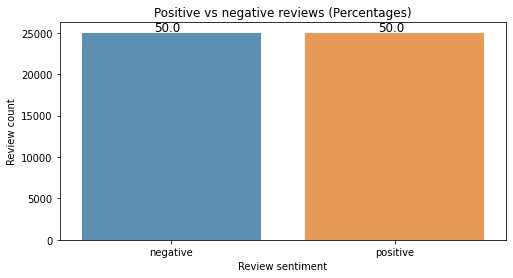

In [ ]:
plt.figure(figsize=(8,4))
ax = sns.barplot(df['sentiment'].value_counts().index, df['sentiment'].value_counts().values, alpha=0.8)
percentage = df['sentiment'].value_counts() / df['sentiment'].shape[0] * 100
perc_count = 0
for p in ax.patches:
  perc = percentage[perc_count]
  x = p.get_x() + p.get_width() / 2 - 0.075 #width established by trial and error
  y = p.get_y() + p.get_height() + 150
  ax.annotate(perc, (x, y), size = 12)
  perc_count+=1
plt.title('Positive vs negative reviews (Percentages)')
plt.xlabel('Review sentiment')
plt.ylabel('Review count')
plt.show()

Here we can se a very balanced dataset (same amount of positive and negative reviews - just like Ruslan mentioned in the lecture). Just to check, if there are no possible NaNs:

In [ ]:
df.isna().sum()

review       0
sentiment    0
dtype: int64

And indeed there are none ;) Let's encode the target values in the 'sentiment' column [1-positive; 0-negetive]:

In [ ]:
df['sentiment'] = df.sentiment.apply(lambda this_df: 1 if this_df == 'positive' else 0)

In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


Cleaning the reviews - while still keeping the initial row in case we need to reuse it later on:

In [ ]:
processed_reviews = []
for i in range(len(df)):
  #let's remove the '<br />' html elements
  rev = df['review'][i].replace('<br />','')
  #let's also remove everything thats not a letter basically 
  rev = re.sub('[^a-zA-Z]', ' ', rev)
  rev = rev.lower().split()
  rev = ' '.join(rev)
  processed_reviews.append(rev)

df['processed_reviews'] = processed_reviews
df.head()

,review,sentiment,processed_reviews
0,One of the other reviewers has mentioned that ...,1,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,1,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,1,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,0,basically there s a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter mattei s love in the time of money is a...


Having done that - we can now either stem or lemmatize the reviews; but we will both for demonstration purposes:

#Stemming & Lemmatizing

In [ ]:
stemmed_reviews = []
for i in range(len(df)):
  #splitting the review into its words
  rev = df['processed_reviews'][i].split()
  ps = PorterStemmer()
  #assigning the stopwords (without 'not') to a variable
  all_stopwords = stopwords.words('english')
  all_stopwords.remove('not')
  rev = [ps.stem(a) for a in rev if not a in set(all_stopwords)]
  rev = ' '.join(rev)
  stemmed_reviews.append(rev)

  #Just for monitoring the process - a cyclical statement
  if (i+1)%5000==0:
    print(f'Processed {i+1} reviews.')

df['stemmed_reviews'] = stemmed_reviews
#just to check the dataframe (there'll be lots of 'df.head()' lines in this homework)
df.head()

Processed 5000 reviews.
Processed 10000 reviews.
Processed 15000 reviews.
Processed 20000 reviews.
Processed 25000 reviews.
Processed 30000 reviews.
Processed 35000 reviews.
Processed 40000 reviews.
Processed 45000 reviews.
Processed 50000 reviews.


,review,sentiment,processed_reviews,stemmed_reviews
0,One of the other reviewers has mentioned that ...,1,one of the other reviewers has mentioned that ...,one review mention watch oz episod hook right ...
1,A wonderful little production. <br /><br />The...,1,a wonderful little production the filming tech...,wonder littl product film techniqu unassum old...
2,I thought this was a wonderful way to spend ti...,1,i thought this was a wonderful way to spend ti...,thought wonder way spend time hot summer weeke...
3,Basically there's a family where a little boy ...,0,basically there s a family where a little boy ...,basic famili littl boy jake think zombi closet...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter mattei s love in the time of money is a...,petter mattei love time money visual stun film...


In [ ]:
"""
Basically the same as stemming
- I could have implemented it above as a conditional if else statement, but I
wanted to keep them separate and not have the cell run too long.
"""
lemmatized_reviews = []
for i in range(len(df)):
  rev = df['processed_reviews'][i].split()
  lemmatizer = WordNetLemmatizer()
  all_stopwords = stopwords.words('english')
  all_stopwords.remove('not')
  rev = [lemmatizer.lemmatize(a) for a in rev if not a in set(all_stopwords)]
  rev = ' '.join(rev)
  lemmatized_reviews.append(rev)


  if (i+1)%5000==0:
    print(f'Processed {i+1} reviews.')

df['lemmatized_reviews'] = lemmatized_reviews
df.head()

Processed 5000 reviews.
Processed 10000 reviews.
Processed 15000 reviews.
Processed 20000 reviews.
Processed 25000 reviews.
Processed 30000 reviews.
Processed 35000 reviews.
Processed 40000 reviews.
Processed 45000 reviews.
Processed 50000 reviews.


,review,sentiment,processed_reviews,stemmed_reviews,lemmatized_reviews
0,One of the other reviewers has mentioned that ...,1,one of the other reviewers has mentioned that ...,one review mention watch oz episod hook right ...,one reviewer mentioned watching oz episode hoo...
1,A wonderful little production. <br /><br />The...,1,a wonderful little production the filming tech...,wonder littl product film techniqu unassum old...,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,1,i thought this was a wonderful way to spend ti...,thought wonder way spend time hot summer weeke...,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,0,basically there s a family where a little boy ...,basic famili littl boy jake think zombi closet...,basically family little boy jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter mattei s love in the time of money is a...,petter mattei love time money visual stun film...,petter mattei love time money visually stunnin...


Let's tokenize the reviews and see the most common words (generally, positive and negative):

##Wordclouds

In [ ]:
'''
I did this at another time than the 'generate_wordcloud' function;
I know that this is a different approach to get to where I want,
But I'll keep it either way.
'''
df['tokenized_lemmatized'] = df['lemmatized_reviews'].apply(lambda df: df.split())
df.head()

,review,sentiment,processed_reviews,stemmed_reviews,lemmatized_reviews,tokenized_lemmatized
0,One of the other reviewers has mentioned that ...,1,one of the other reviewers has mentioned that ...,one review mention watch oz episod hook right ...,one reviewer mentioned watching oz episode hoo...,"[one, reviewer, mentioned, watching, oz, episo..."
1,A wonderful little production. <br /><br />The...,1,a wonderful little production the filming tech...,wonder littl product film techniqu unassum old...,wonderful little production filming technique ...,"[wonderful, little, production, filming, techn..."
2,I thought this was a wonderful way to spend ti...,1,i thought this was a wonderful way to spend ti...,thought wonder way spend time hot summer weeke...,thought wonderful way spend time hot summer we...,"[thought, wonderful, way, spend, time, hot, su..."
3,Basically there's a family where a little boy ...,0,basically there s a family where a little boy ...,basic famili littl boy jake think zombi closet...,basically family little boy jake think zombie ...,"[basically, family, little, boy, jake, think, ..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter mattei s love in the time of money is a...,petter mattei love time money visual stun film...,petter mattei love time money visually stunnin...,"[petter, mattei, love, time, money, visually, ..."


In [ ]:
positive_df = df.loc[df['sentiment']==1]
positive_df = positive_df.reset_index(drop=True)
positive_df[:2].head()

,review,sentiment,processed_reviews,stemmed_reviews,lemmatized_reviews,tokenized_lemmatized
0,One of the other reviewers has mentioned that ...,1,one of the other reviewers has mentioned that ...,one review mention watch oz episod hook right ...,one reviewer mentioned watching oz episode hoo...,"[one, reviewer, mentioned, watching, oz, episo..."
1,A wonderful little production. <br /><br />The...,1,a wonderful little production the filming tech...,wonder littl product film techniqu unassum old...,wonderful little production filming technique ...,"[wonderful, little, production, filming, techn..."


In [ ]:
negative_df = df.loc[df['sentiment']==0]
negative_df = negative_df.reset_index(drop=True)
negative_df[:2].head()

,review,sentiment,processed_reviews,stemmed_reviews,lemmatized_reviews,tokenized_lemmatized
0,Basically there's a family where a little boy ...,0,basically there s a family where a little boy ...,basic famili littl boy jake think zombi closet...,basically family little boy jake think zombie ...,"[basically, family, little, boy, jake, think, ..."
1,"This show was an amazing, fresh & innovative i...",0,this show was an amazing fresh innovative idea...,show amaz fresh innov idea first air first yea...,show amazing fresh innovative idea first aired...,"[show, amazing, fresh, innovative, idea, first..."


In [ ]:
def generate_wordcloud(reviews):

  print(f'Number of rows in column: {len(reviews)}')
  #This is what I meant before - this is an easier way for tokenization
  words = ' '.join(reviews)
  print(f'Number of words in column: {len(words)}')

  print('Generating wordcloud...')
  plt.figure(figsize=(10,6))
  wordcloud = WordCloud(stopwords=STOPWORDS,
                        background_color='black',
                        width=3000,
                        height=2500
                      ).generate(words)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()


Number of rows in column: 50000
Number of words in column: 62465375
Generating wordcloud...


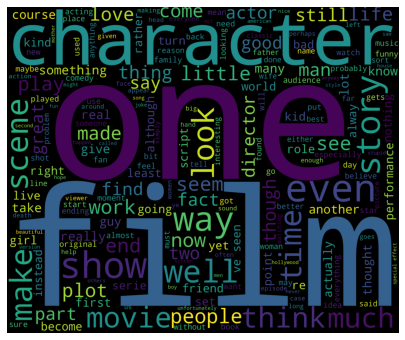

In [ ]:
generate_wordcloud(reviews=df['processed_reviews'])

Number of rows in column: 25000
Number of words in column: 31642170
Generating wordcloud...


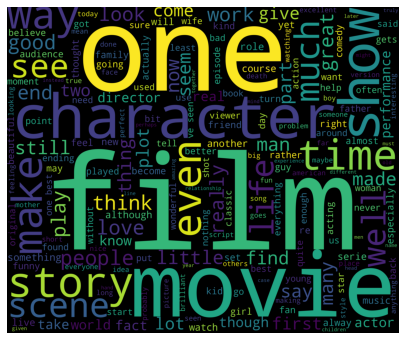

In [ ]:
generate_wordcloud(reviews=positive_df['processed_reviews'])

Number of rows in column: 25000
Number of words in column: 30823204
Generating wordcloud...


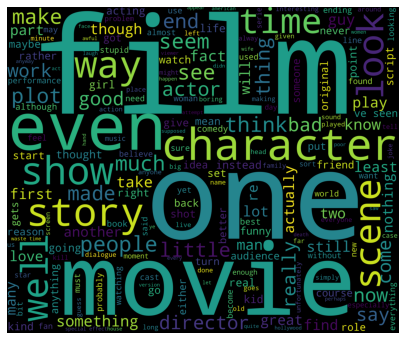

In [ ]:
generate_wordcloud(reviews=negative_df['processed_reviews'])

## Most frequent features

In [ ]:
def find_most_common(dataframe, top_number=10):
  t_l_list = dataframe['tokenized_lemmatized'].to_list()
  t_l_list = list(itertools.chain.from_iterable(t_l_list))
  print(f'Number of words total: {len(t_l_list)}')
  print(f'The {top_number} most frequent words:')
  fdist = FreqDist(t_l_list)
  return fdist.most_common(top_number)

In [ ]:
find_most_common(df)

Number of words total: 5967850
The 10 most frequent words:


[('movie', 103239),
 ('film', 93428),
 ('not', 60736),
 ('one', 55432),
 ('like', 41120),
 ('time', 31456),
 ('good', 29852),
 ('character', 28344),
 ('story', 25263),
 ('even', 24857)]

In [ ]:
find_most_common(positive_df)

Number of words total: 3026798
The 10 most frequent words:


[('film', 49693),
 ('movie', 44836),
 ('not', 28300),
 ('one', 28280),
 ('like', 18193),
 ('time', 16310),
 ('good', 15089),
 ('story', 14181),
 ('character', 14020),
 ('great', 13009)]

In [ ]:
find_most_common(negative_df)

Number of words total: 2941052
The 10 most frequent words:


[('movie', 58403),
 ('film', 43735),
 ('not', 32436),
 ('one', 27152),
 ('like', 22927),
 ('even', 15244),
 ('time', 15146),
 ('good', 14763),
 ('bad', 14714),
 ('character', 14324)]

I might return to these wordclouds and most frequent features -  because I think that words such as 'film', 'one' and 'movie' can be considered stopwords

## Rough assessment of classifiers - helper function

Let's make a function which broadly assesses the accuracy when using a specific vectorizer, classifier, maximum features and lemmatization/stemming:

In [ ]:
def assess_vectorizer(clf, X_type, vectorizer, vect_features=500, provide_extra_info=False):
  vect = vectorizer(max_features=vect_features)
  X = vect.fit_transform(X_type).toarray()
  y = df.sentiment.values

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 10)
  
  classifier = clf()
  classifier.fit(X_train, y_train)

  y_pred = classifier.predict(X_test)
  
  if provide_extra_info:
    print('Comparison table [pred vs test]:')
    print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

    cm = confusion_matrix(y_test, y_pred)
    print('\nConfusion matrix:\n')
    print(f'{cm}\n')
  
  return accuracy_score(y_test, y_pred)

  

Two trial runs, just to check the function:

In [ ]:
assess_vectorizer(clf=LogisticRegression, X_type= df['stemmed_reviews'], vectorizer=CountVectorizer, vect_features=400, provide_extra_info=True)

Comparison table [pred vs test]:
[[1 1]
 [0 0]
 [1 1]
 ...
 [0 0]
 [0 0]
 [0 1]]

Confusion matrix:

[[4159  949]
 [ 688 4204]]



0.8363

In [ ]:
assess_vectorizer(clf=GaussianNB, X_type= df['stemmed_reviews'], vectorizer=CountVectorizer, vect_features=400, provide_extra_info=True)

Comparison table [pred vs test]:
[[0 1]
 [0 0]
 [1 1]
 ...
 [0 0]
 [0 0]
 [0 1]]

Confusion matrix:

[[3968 1140]
 [ 856 4036]]



0.8004

- OK, so this function works: What I am interested in is what the relationship between number of features and accuracy, to see if I can draw some preliminary conclusions and use an optimal amount of features for hyperparameter tuning:
- (What you won't see for now is the SVC classifier, which was computationally heavy on the dataset itself, so I'll have to subsample the dataset and then try - but more on that later, for now I'll do some screening on the other clasisfiers)

#Screening number of features

I'll be screening the following classifiers:
- LogisticREgression
- SGD
- GaussianNB
- MultinomialNB
- SVC

In [ ]:
def accuracy_screening(clf, X_type, starting_point=0, count=10, rate=100):
  feature_no_list = []
  cv_list = []
  tfidf_list = []

  for i in range(count):
    vect_count = ((i+1)*rate) + starting_point
    cv_accuracy = assess_vectorizer(clf, X_type, vectorizer=CountVectorizer, vect_features= vect_count)
    tfidf_accuracy = assess_vectorizer(clf, X_type, vectorizer=TfidfVectorizer, vect_features= vect_count)

    feature_no_list.append(vect_count)
    cv_list.append(cv_accuracy)
    tfidf_list.append(tfidf_accuracy) 
    print(f'Calculated accuracy for {vect_count} features')

  accuracy_data = {'number_of_features': feature_no_list,'cv_accuracy': cv_list,'tfidf_accuracy': tfidf_list}
  screening_df = pd.DataFrame(accuracy_data)
  screening_df.plot(x='number_of_features', y=['cv_accuracy', 'tfidf_accuracy'], figsize=(10,5), grid=True, 
                    xticks=screening_df['number_of_features'])
  plt.show()

##Logistic Regression

Calculated accuracy for 200 features
Calculated accuracy for 400 features
Calculated accuracy for 600 features
Calculated accuracy for 800 features
Calculated accuracy for 1000 features
Calculated accuracy for 1200 features
Calculated accuracy for 1400 features
Calculated accuracy for 1600 features
Calculated accuracy for 1800 features
Calculated accuracy for 2000 features


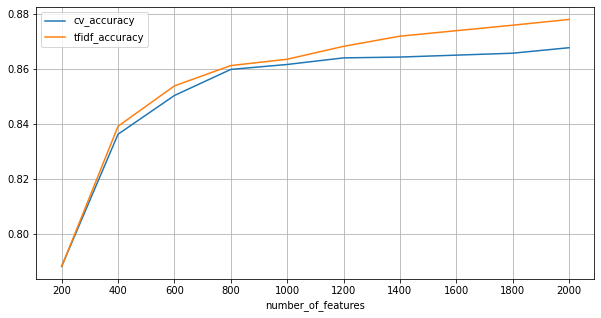

In [ ]:
 accuracy_screening(clf=LogisticRegression, X_type=df['stemmed_reviews'], starting_point=0, count=10, rate=200)

Calculated accuracy for 200 features
Calculated accuracy for 400 features
Calculated accuracy for 600 features
Calculated accuracy for 800 features
Calculated accuracy for 1000 features
Calculated accuracy for 1200 features
Calculated accuracy for 1400 features
Calculated accuracy for 1600 features
Calculated accuracy for 1800 features
Calculated accuracy for 2000 features


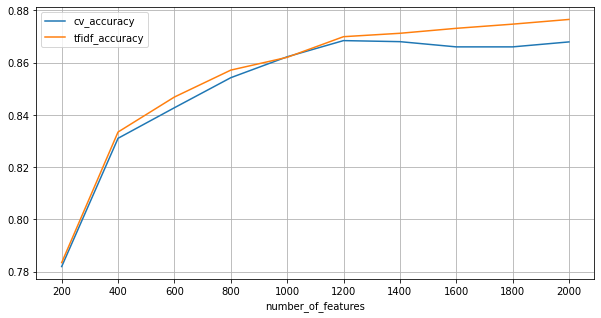

In [ ]:
 accuracy_screening(clf=LogisticRegression, X_type=df['lemmatized_reviews'], starting_point=0, count=10, rate=200)

##SGDClassifier

Calculated accuracy for 200 features
Calculated accuracy for 400 features
Calculated accuracy for 600 features
Calculated accuracy for 800 features
Calculated accuracy for 1000 features
Calculated accuracy for 1200 features
Calculated accuracy for 1400 features
Calculated accuracy for 1600 features
Calculated accuracy for 1800 features
Calculated accuracy for 2000 features


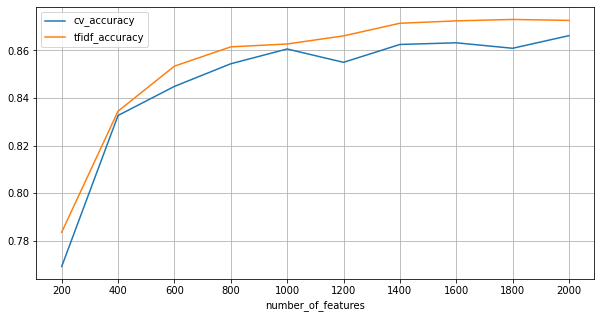

In [ ]:
accuracy_screening(clf=SGDClassifier, X_type=df['stemmed_reviews'], starting_point=0, count=10, rate=200)

Calculated accuracy for 200 features
Calculated accuracy for 400 features
Calculated accuracy for 600 features
Calculated accuracy for 800 features
Calculated accuracy for 1000 features
Calculated accuracy for 1200 features
Calculated accuracy for 1400 features
Calculated accuracy for 1600 features
Calculated accuracy for 1800 features
Calculated accuracy for 2000 features


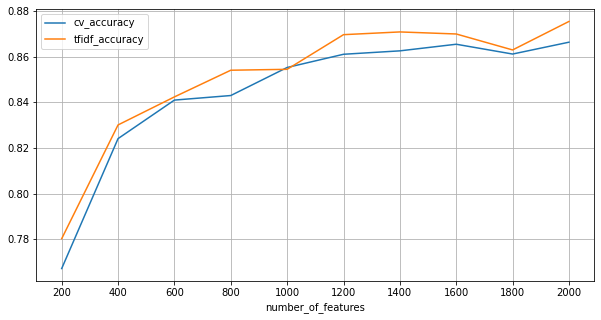

In [ ]:
accuracy_screening(clf=SGDClassifier, X_type=df['lemmatized_reviews'], starting_point=0, count=10, rate=200)

##GaussianNB

Calculated accuracy for 200 features
Calculated accuracy for 400 features
Calculated accuracy for 600 features
Calculated accuracy for 800 features
Calculated accuracy for 1000 features
Calculated accuracy for 1200 features
Calculated accuracy for 1400 features
Calculated accuracy for 1600 features
Calculated accuracy for 1800 features
Calculated accuracy for 2000 features


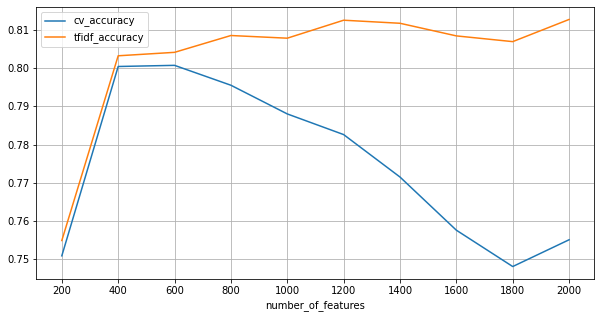

In [ ]:
accuracy_screening(clf=GaussianNB, X_type=df['stemmed_reviews'], starting_point=0, count=10, rate=200)

Calculated accuracy for 200 features
Calculated accuracy for 400 features
Calculated accuracy for 600 features
Calculated accuracy for 800 features
Calculated accuracy for 1000 features
Calculated accuracy for 1200 features
Calculated accuracy for 1400 features
Calculated accuracy for 1600 features
Calculated accuracy for 1800 features
Calculated accuracy for 2000 features


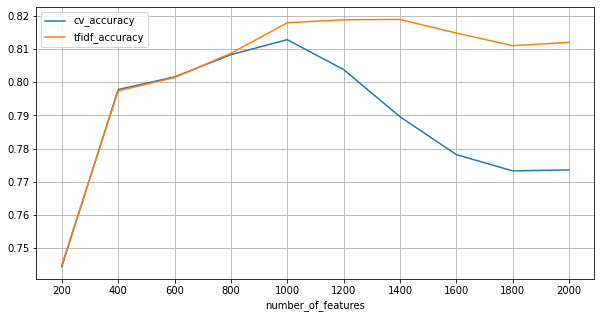

In [ ]:
accuracy_screening(clf=GaussianNB, X_type=df['lemmatized_reviews'], starting_point=0, count=10, rate=200)

##MultinomialNB

Calculated accuracy for 200 features
Calculated accuracy for 400 features
Calculated accuracy for 600 features
Calculated accuracy for 800 features
Calculated accuracy for 1000 features
Calculated accuracy for 1200 features
Calculated accuracy for 1400 features
Calculated accuracy for 1600 features
Calculated accuracy for 1800 features
Calculated accuracy for 2000 features


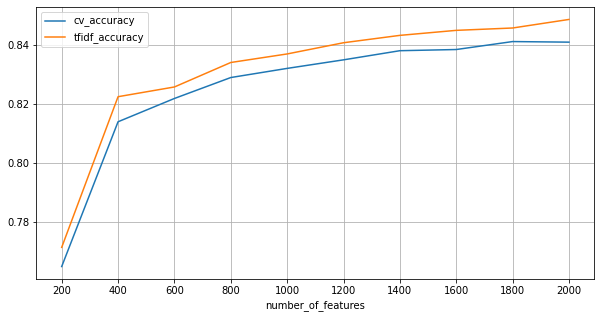

In [ ]:
accuracy_screening(clf=MultinomialNB, X_type=df['stemmed_reviews'], starting_point=0, count=10, rate=200)

Calculated accuracy for 200 features
Calculated accuracy for 400 features
Calculated accuracy for 600 features
Calculated accuracy for 800 features
Calculated accuracy for 1000 features
Calculated accuracy for 1200 features
Calculated accuracy for 1400 features
Calculated accuracy for 1600 features
Calculated accuracy for 1800 features
Calculated accuracy for 2000 features


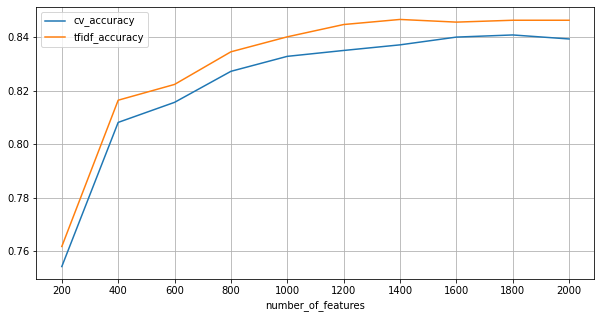

In [ ]:
accuracy_screening(clf=MultinomialNB, X_type=df['lemmatized_reviews'], starting_point=0, count=10, rate=200)

##SVC

While I would like to use my fancy function to assess the accuracy and do a similar screening of the accuracy for SVC - it is too heavy computationally, and I need to do two things:
- take a subsample
- choose a bigger rate of intervals for the screening

That's why I'll modify the code a bit and make some special functions just for SVC:

In [ ]:
def svc_assess_vectorizer(X_type, vectorizer, vect_features=500):
  vect = vectorizer(max_features=vect_features)
  X = vect.fit_transform(X_type).toarray()
  y = df.sentiment.values

  X_sample = X[::5].copy()
  y_sample = y[::5].copy()

  X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size = 0.20, random_state = 10)

  classifier = SVC(kernel='rbf', probability=False)
  classifier.fit(X_train, y_train)

  y_pred = classifier.predict(X_test)
  return accuracy_score(y_test, y_pred)

In [ ]:
def svc_accuracy_screening(X_type, starting_point=0, count=4, rate=500):
  feature_no_list = []
  cv_list = []
  tfidf_list = []

  for i in range(count):
    vect_count = ((i+1)*rate) + starting_point
    cv_accuracy = svc_assess_vectorizer(X_type, vectorizer=CountVectorizer, vect_features= vect_count)
    tfidf_accuracy = svc_assess_vectorizer(X_type, vectorizer=TfidfVectorizer, vect_features= vect_count)

    feature_no_list.append(vect_count)
    cv_list.append(cv_accuracy)
    tfidf_list.append(tfidf_accuracy) 
    print(f'Calculated accuracy for {vect_count} features')

  accuracy_data = {'number_of_features': feature_no_list,'cv_accuracy': cv_list,'tfidf_accuracy': tfidf_list}
  screening_df = pd.DataFrame(accuracy_data)
  screening_df.plot(x='number_of_features', y=['cv_accuracy', 'tfidf_accuracy'], figsize=(10,5), grid=True, 
                    xticks=screening_df['number_of_features'])
  plt.show()

Calculated accuracy for 500 features
Calculated accuracy for 1000 features
Calculated accuracy for 1500 features
Calculated accuracy for 2000 features


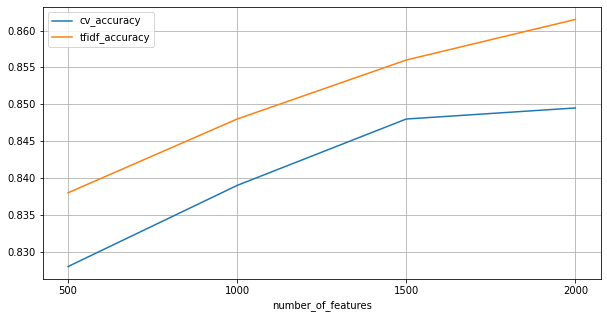

In [ ]:
svc_accuracy_screening(X_type=df['stemmed_reviews'],starting_point=0, count=4, rate=500)

Calculated accuracy for 500 features
Calculated accuracy for 1000 features
Calculated accuracy for 1500 features
Calculated accuracy for 2000 features


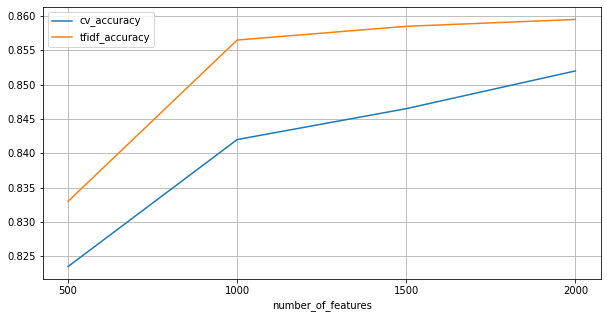

In [ ]:
svc_accuracy_screening(X_type=df['lemmatized_reviews'],starting_point=0, count=4, rate=500)

SVC is worse in terms of accuracy - definitely not worth the computational toll it takes to compute this - around 0.84-0.85 accuracy for the 1000 features I wanted to choose for further optimization. Not worth it. I would probably pass on SVC in this case, but for the homework itself I'll do some hyperparameter tuning.

##Feature number screening - conclusions

- Lemmatization provided the better results
- So did TFIDF as a vectorization approach
- From the Naive Bayes classifiers, Multinomial was indeed better (I'll choose it for hyperparameter tuning - besides, theres nothing to tune in GaussianNB)
- Simple LogisticRegression was quite good ;)
- SVC is totally not worth the computational toll it takes to compute the accuracy (I would ideally drop this classifier and focus on more efficient ones)

#Hyperparameter tuning

Assumptions:
- Stick to lemmatization
- Use 1200 max features
- TF IDF embedding
- Classifiers evaluated: LogReg, SGDClassifier, MultinomialNB, SVC [hopefully this one won't give me too much pain]


##Logistic Regression

In [ ]:
X = df['lemmatized_reviews']
y = df.sentiment.values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 10)

In [ ]:
logreg_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=1200) ),
    ('logreg', LogisticRegression())
])

parameters = {'logreg__C': [0.05, 0.1, 1, 5]}

grid_search = GridSearchCV(logreg_pipeline, param_grid=parameters,
                          cv=StratifiedKFold(5), scoring='f1', verbose=2)

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] logreg__C=0.05 ..................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................... logreg__C=0.05, total=   4.5s
[CV] logreg__C=0.05 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s


[CV] ................................... logreg__C=0.05, total=   4.4s
[CV] logreg__C=0.05 ..................................................
[CV] ................................... logreg__C=0.05, total=   4.4s
[CV] logreg__C=0.05 ..................................................
[CV] ................................... logreg__C=0.05, total=   4.4s
[CV] logreg__C=0.05 ..................................................
[CV] ................................... logreg__C=0.05, total=   4.4s
[CV] logreg__C=0.1 ...................................................
[CV] .................................... logreg__C=0.1, total=   4.5s
[CV] logreg__C=0.1 ...................................................
[CV] .................................... logreg__C=0.1, total=   4.5s
[CV] logreg__C=0.1 ...................................................
[CV] .................................... logreg__C=0.1, total=   4.5s
[CV] logreg__C=0.1 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.6min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=1200,
                                                        min_df=1,
                                                       

In [ ]:
y_pred = grid_search.predict(X_test)
logreg_cv_df = pd.DataFrame(grid_search.cv_results_)
logreg_cv_df[['param_logreg__C','mean_test_score']]

,param_logreg__C,mean_test_score
0,0.05,0.857401
1,0.1,0.863226
2,1,0.870691
3,5,0.869630


In [ ]:
grid_search.best_params_

{'logreg__C': 1}

In [ ]:
grid_search.best_score_

0.8706909962068907

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87      5108
           1       0.85      0.89      0.87      4892

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



##SGDClassifier

In [ ]:
sgd_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=1200) ),
    ('sgd', SGDClassifier())
])

parameters = {'sgd__alpha': [0.0001, 0.001, 0.01, 0.1, 1]}

grid_search = GridSearchCV(sgd_pipeline, param_grid=parameters,
                          cv=StratifiedKFold(5), scoring='f1', verbose=2)

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] sgd__alpha=0.0001 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................ sgd__alpha=0.0001, total=   4.4s
[CV] sgd__alpha=0.0001 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s


[CV] ................................ sgd__alpha=0.0001, total=   4.4s
[CV] sgd__alpha=0.0001 ...............................................
[CV] ................................ sgd__alpha=0.0001, total=   4.4s
[CV] sgd__alpha=0.0001 ...............................................
[CV] ................................ sgd__alpha=0.0001, total=   4.4s
[CV] sgd__alpha=0.0001 ...............................................
[CV] ................................ sgd__alpha=0.0001, total=   4.4s
[CV] sgd__alpha=0.001 ................................................
[CV] ................................. sgd__alpha=0.001, total=   4.3s
[CV] sgd__alpha=0.001 ................................................
[CV] ................................. sgd__alpha=0.001, total=   4.3s
[CV] sgd__alpha=0.001 ................................................
[CV] ................................. sgd__alpha=0.001, total=   4.3s
[CV] sgd__alpha=0.001 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  1.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=1200,
                                                        min_df=1,
                                                       

In [ ]:
y_pred = grid_search.predict(X_test)
sgd_cv_df = pd.DataFrame(grid_search.cv_results_)
sgd_cv_df[['param_sgd__alpha','mean_test_score']]

,param_sgd__alpha,mean_test_score
0,0.0001,0.870353
1,0.001,0.862797
2,0.01,0.815859
3,0.1,0.715535
4,1,0.457452


In [ ]:
grid_search.best_params_

{'sgd__alpha': 0.0001}

In [ ]:
grid_search.best_score_

0.8703533318568976

##MultinomialNB

In [ ]:
NB_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=1200) ),
    ('NB', MultinomialNB())
])

parameters = [{'NB__alpha': [0, 0.5, 1.0, 5, 10], 'NB__fit_prior':[True, False]}]

grid_search = GridSearchCV(NB_pipeline, param_grid=parameters,
                          cv=StratifiedKFold(5), scoring='f1', verbose=2)

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] NB__alpha=0, NB__fit_prior=True .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................. NB__alpha=0, NB__fit_prior=True, total=   4.3s
[CV] NB__alpha=0, NB__fit_prior=True .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s


[CV] .................. NB__alpha=0, NB__fit_prior=True, total=   4.3s
[CV] NB__alpha=0, NB__fit_prior=True .................................
[CV] .................. NB__alpha=0, NB__fit_prior=True, total=   4.2s
[CV] NB__alpha=0, NB__fit_prior=True .................................
[CV] .................. NB__alpha=0, NB__fit_prior=True, total=   4.2s
[CV] NB__alpha=0, NB__fit_prior=True .................................
[CV] .................. NB__alpha=0, NB__fit_prior=True, total=   4.3s
[CV] NB__alpha=0, NB__fit_prior=False ................................
[CV] ................. NB__alpha=0, NB__fit_prior=False, total=   4.2s
[CV] NB__alpha=0, NB__fit_prior=False ................................
[CV] ................. NB__alpha=0, NB__fit_prior=False, total=   4.2s
[CV] NB__alpha=0, NB__fit_prior=False ................................
[CV] ................. NB__alpha=0, NB__fit_prior=False, total=   4.2s
[CV] NB__alpha=0, NB__fit_prior=False ................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=1200,
                                                        min_df=1,
                                                       

In [ ]:
y_pred = grid_search.predict(X_test)
NB_cv_df = pd.DataFrame(grid_search.cv_results_)
NB_cv_df[['param_NB__alpha','param_NB__fit_prior','mean_test_score']]

,param_NB__alpha,param_NB__fit_prior,mean_test_score
0,0,True,0.845802
1,0,False,0.845558
2,0.5,True,0.846012
3,0.5,False,0.845734
4,1,True,0.845962
5,1,False,0.845636
6,5,True,0.846083
7,5,False,0.845418
8,10,True,0.846015
9,10,False,0.845125


In [ ]:
grid_search.best_params_

{'NB__alpha': 5, 'NB__fit_prior': True}

In [ ]:
grid_search.best_score_

0.8460830424353161

##SVC

I will decrease the sample size to make the classifier and cross-validation run faster (10-fold decrease)

In [ ]:
X_sample = X[::10].copy()
y_sample = y[::10].copy()

X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size = 0.20, random_state = 10)

In [ ]:
svc_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=1200) ),
    ('svc', SVC())])

parameters = [{'svc__kernel': ['rbf'], 'svc__gamma': [1e-3, 1e-4],
                     'svc__C': [1, 10, 100, 1000]},]

grid_search = GridSearchCV(svc_pipeline, param_grid=parameters,
                          cv=StratifiedKFold(5), scoring='f1', verbose=2)

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] svc__C=1, svc__gamma=0.001, svc__kernel=rbf .....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... svc__C=1, svc__gamma=0.001, svc__kernel=rbf, total=   8.6s
[CV] svc__C=1, svc__gamma=0.001, svc__kernel=rbf .....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.6s remaining:    0.0s


[CV] ...... svc__C=1, svc__gamma=0.001, svc__kernel=rbf, total=   8.6s
[CV] svc__C=1, svc__gamma=0.001, svc__kernel=rbf .....................
[CV] ...... svc__C=1, svc__gamma=0.001, svc__kernel=rbf, total=   8.6s
[CV] svc__C=1, svc__gamma=0.001, svc__kernel=rbf .....................
[CV] ...... svc__C=1, svc__gamma=0.001, svc__kernel=rbf, total=   8.7s
[CV] svc__C=1, svc__gamma=0.001, svc__kernel=rbf .....................
[CV] ...... svc__C=1, svc__gamma=0.001, svc__kernel=rbf, total=   8.6s
[CV] svc__C=1, svc__gamma=0.0001, svc__kernel=rbf ....................
[CV] ..... svc__C=1, svc__gamma=0.0001, svc__kernel=rbf, total=   8.6s
[CV] svc__C=1, svc__gamma=0.0001, svc__kernel=rbf ....................
[CV] ..... svc__C=1, svc__gamma=0.0001, svc__kernel=rbf, total=   8.6s
[CV] svc__C=1, svc__gamma=0.0001, svc__kernel=rbf ....................
[CV] ..... svc__C=1, svc__gamma=0.0001, svc__kernel=rbf, total=   8.7s
[CV] svc__C=1, svc__gamma=0.0001, svc__kernel=rbf ....................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  5.1min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=1200,
                                                        min_df=1,
                                                       

In [ ]:
y_pred = grid_search.predict(X_test)
svc_cv_df = pd.DataFrame(grid_search.cv_results_)
svc_cv_df[['param_svc__C','param_svc__gamma','mean_test_score']]

,param_svc__C,param_svc__gamma,mean_test_score
0,1,0.001,0.669992
1,1,0.0001,0.669992
2,10,0.001,0.685608
3,10,0.0001,0.669992
4,100,0.001,0.844826
5,100,0.0001,0.685842
6,1000,0.001,0.829004
7,1000,0.0001,0.844830


In [ ]:
grid_search.best_params_

{'svc__C': 1000, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}

In [ ]:
grid_search.best_score_

0.8448295524851858

#ROC scores and curves

So let's take the best parameters for all the classifiers to the test and establish once and for all, which would be the best! Keep in mind the previous assumptions:
- Lemmatization
- TFIDF
- 1200 max features

The parameters for each Classifier are:
- LogisticRegression: {'logreg__C': 1}
- SGDCLassifier: {'sgd__alpha': 0.0001}
- MultinomialNB: {'NB__alpha': 5, 'NB__fit_prior': True}
- SVC: {'svc__C': 1000, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}


In [ ]:
X = df['lemmatized_reviews']
y = df.sentiment.values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 10)

In [ ]:
logreg_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=1200) ),
    ('logreg', LogisticRegression(C=1))
])

logreg_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=1200,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('logreg',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_s

In [ ]:
logreg_probs = logreg_pipeline.predict_proba(X_test)

In [ ]:
logreg_probs

array([[0.25041464, 0.74958536],
       [0.808113  , 0.191887  ],
       [0.24502556, 0.75497444],
       ...,
       [0.99056296, 0.00943704],
       [0.93786457, 0.06213543],
       [0.78515111, 0.21484889]])

In [ ]:
logreg_probs = logreg_probs[:, 1]

In [ ]:
logreg_auc = roc_auc_score(y_test, logreg_probs)
logreg_auc

0.9434923157748478

In [ ]:
logreg_fpr, logreg_tpr, _ = roc_curve(y_test, logreg_probs)

And now for the other ones, one cell per Classifier:

In [ ]:
sgd_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=1200) ),
    ('sgd', SGDClassifier(alpha=0.0001))
])

sgd_pipeline.fit(X_train, y_train)

sgd_probs = sgd_pipeline.decision_function(X_test)
sgd_auc = roc_auc_score(y_test, sgd_probs)

sgd_fpr, sgd_tpr, _ = roc_curve(y_test, sgd_probs)

In [ ]:
NB_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=1200) ),
    ('NB', MultinomialNB(alpha=5, fit_prior=True))
])

NB_pipeline.fit(X_train, y_train)

NB_probs = NB_pipeline.predict_proba(X_test)
NB_probs = NB_probs[:, 1]
NB_auc = roc_auc_score(y_test, NB_probs)

NB_fpr, NB_tpr, _ = roc_curve(y_test, NB_probs)

In [ ]:
X_sample = X[::10].copy()
y_sample = y[::10].copy()

X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size = 0.20, random_state = 10)

In [ ]:
SVC_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=1200) ),
    ('svc', SVC(C=1000, gamma=0.0001, kernel='rbf', probability=True))])
SVC_pipeline.fit(X_train, y_train)

SVC_probs = SVC_pipeline.predict_proba(X_test)
SVC_probs = SVC_probs[:, 1]
SVC_auc = roc_auc_score(y_test, SVC_probs)

SVC_fpr, SVC_tpr, _ = roc_curve(y_test, SVC_probs)

Let's put it all together, finally:

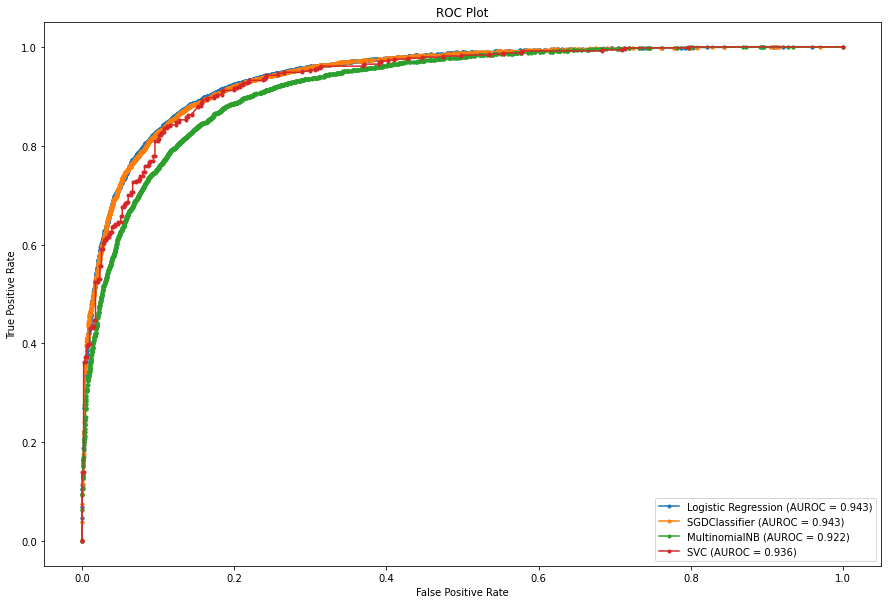

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(logreg_fpr, logreg_tpr, marker='.', label='Logistic Regression (AUROC = %0.3f)' % logreg_auc)
plt.plot(sgd_fpr, sgd_tpr, marker='.', label='SGDClassifier (AUROC = %0.3f)' % sgd_auc)
plt.plot(NB_fpr, NB_tpr, marker='.', label='MultinomialNB (AUROC = %0.3f)' % NB_auc)
plt.plot(SVC_fpr, SVC_tpr, marker='.', label='SVC (AUROC = %0.3f)' % SVC_auc)

plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

As you can see, both LogisticRegression and SGDClassifier have the highest AUROC score. The worst score is found by using the MultinomialNB Naive Bayes classifier. But these three classifiers were pretty efficient.
The biggest problems were found with the SVC classifier, as it turned out to be the most computationally heavy classifier, but didn't produce better results (it has a score between the NB and LogReg classifiers)

Whether or not it was the best idea to indiscriminately extract every tenth sample for the SVC classifier, I'm not sure. But this was a decision mandated by the issues I had with actually computing the model. For that reason, I wouldn't use SVC for my NLP sentiment analysis with datasets this big.

#Conclusions

Let's take a randomly picked review from IMDB about Avengers Endgame:

In [ ]:
rev = 'I had no choice but to watch it to finish the sequence. The worst of all the Avengers movies. Apart from some action scenes all the rest it is pure lame dialogues and poor performances. Purely made to make money out of a "trendy" public that are rating this movie high because I\'ve never met one single person who has read the comics and like this garbage. At least, there will be no more of this, I hope.'

In [ ]:
rev = rev.replace('<br />','')
#let's also remove everything thats not a letter basically 
rev = re.sub('[^a-zA-Z]', ' ', rev)
rev = rev.lower().split()
rev = ' '.join(rev)
rev

'i had no choice but to watch it to finish the sequence the worst of all the avengers movies apart from some action scenes all the rest it is pure lame dialogues and poor performances purely made to make money out of a trendy public that are rating this movie high because i ve never met one single person who has read the comics and like this garbage at least there will be no more of this i hope'

In [ ]:
rev2 = rev.split()
lemmatizer = WordNetLemmatizer()
all_stopwords = stopwords.words('english')
all_stopwords.remove('not')
rev2 = [lemmatizer.lemmatize(a) for a in rev2 if not a in set(all_stopwords)]
rev2 = ' '.join(rev2)
rev2

'choice watch finish sequence worst avenger movie apart action scene rest pure lame dialogue poor performance purely made make money trendy public rating movie high never met one single person read comic like garbage least hope'

In [ ]:
trial_review = {'review': [rev2], 'sentiment': [0]}
trial_review_df = pd.DataFrame.from_dict(data=trial_review)
trial_review_df

,review,sentiment
0,choice watch finish sequence worst avenger mov...,0


In [ ]:
X_tesst = trial_review_df['review']

In [ ]:
logreg_pipeline.predict(X_tesst)

array([0])

In [ ]:
sgd_pipeline.predict(X_tesst)

array([0])

In [ ]:
NB_pipeline.predict(X_tesst)

array([0])

In [ ]:
SVC_pipeline.predict(X_tesst)

array([0])

Yay - it works! The different models predicted that the randomly copied review that I found would be labeled as a negative review. I thought that this would be a nice informal and fun little bonus exercise to try out :)

#Final thoughts

This was a fun adventure - although I was underestimating the dataset. Re-running some of the classification and all of the crashes in-between have taught me a bit humility. Nevertheless, I am really happy with the result - the accuracies and AUROC scores are nothing to scoff at ;)

A few things I wish I had time to explore/could be improved:
- removing a few words, which could be considered stopwords (film, movie, one)
- actually performing the feature importance step
- checking, if SVC could be optimized in another way to not take forever to run (doing a better job than to just take every tenth sample)
- some refactoring here and there ;)
- trying to play with n-grams (eg. 'not good') to increase the accuracy